#Mounting Drive & unzipping Dataset


In [2]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#unzipping dataset
!unzip '/content/drive/MyDrive/newfolder/visualsimilarity.zip' -d ./

Archive:  /content/drive/MyDrive/newfolder/visualsimilarity.zip
   creating: ./bottoms_resized_png/
  inflating: ./bottoms_resized_png/13079565VVD.png  
  inflating: ./bottoms_resized_png/13079565VVR.png  
  inflating: ./bottoms_resized_png/13108390UDD.png  
  inflating: ./bottoms_resized_png/13108390UDR.png  
  inflating: ./bottoms_resized_png/13110484CLD.png  
  inflating: ./bottoms_resized_png/13110484CLR.png  
  inflating: ./bottoms_resized_png/13162479UBD.png  
  inflating: ./bottoms_resized_png/13162479UBR.png  
  inflating: ./bottoms_resized_png/13180761CUD.png  
  inflating: ./bottoms_resized_png/13180761CUR.png  
  inflating: ./bottoms_resized_png/13192537MCD.png  
  inflating: ./bottoms_resized_png/13192537MCR.png  
  inflating: ./bottoms_resized_png/13224618QUD.png  
  inflating: ./bottoms_resized_png/13224618QUR.png  
  inflating: ./bottoms_resized_png/13260596HKD.png  
  inflating: ./bottoms_resized_png/13260596HKR.png  
  inflating: ./bottoms_resized_png/13315564GCD.png  

In [6]:
len(os.listdir('/content/bottoms_resized_png'))

1050

#Data at a glance (Visualization)

In [1]:
#importing libraries
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

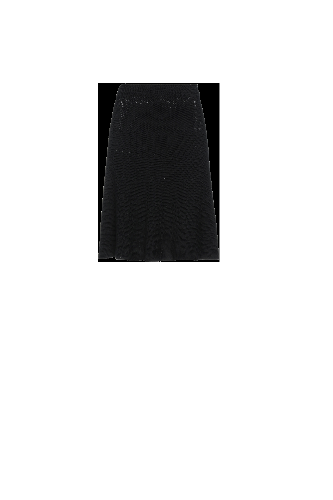

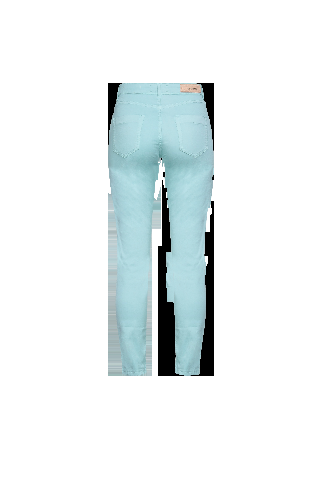

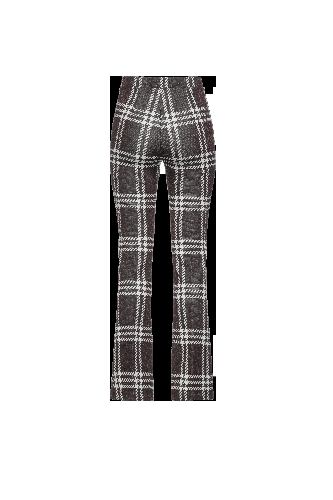

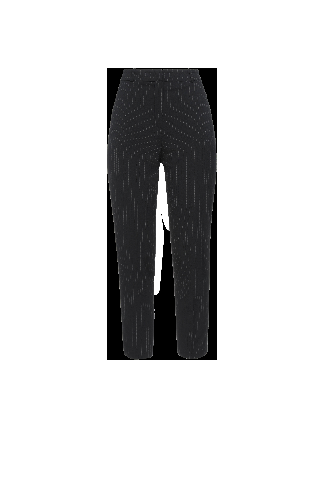

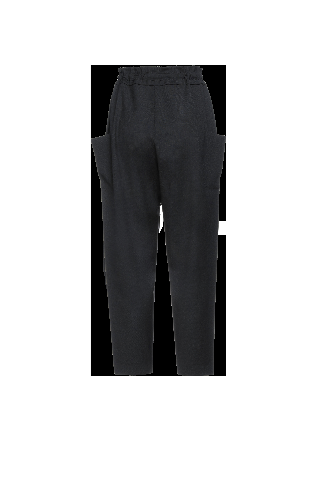

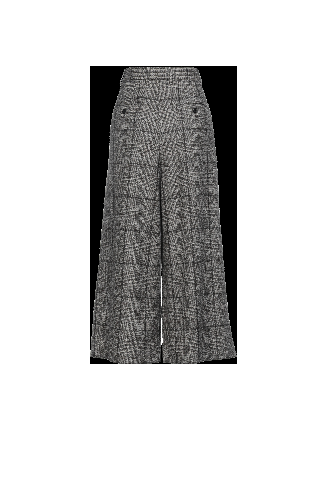

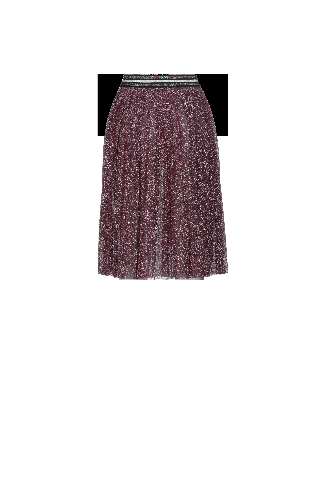

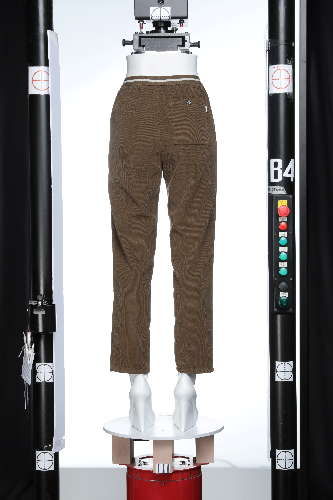

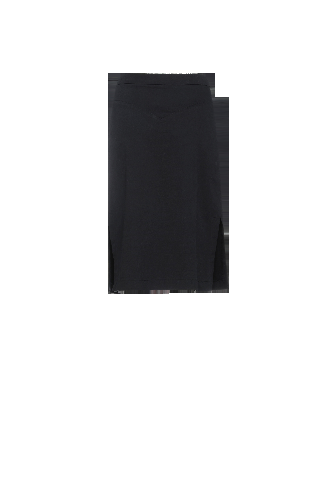

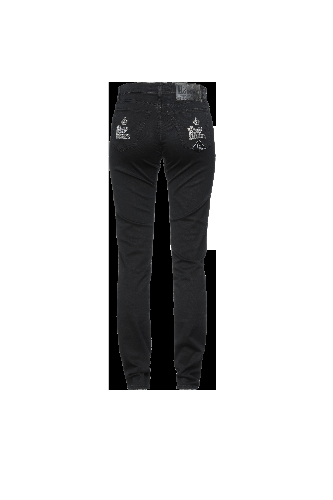

In [2]:
#visualizing 10 images from the dataset
img_path = '/content/bottoms_resized_png'
images_list = os.listdir(img_path)

for i in range(10):
  img = cv2.imread(f"{img_path}/{images_list[i]}")
  cv2_imshow(img)

#Making DataLoader

In [278]:
#Declaring some important execution stuff
BATCH_SIZE=8
SIZE = 224
DEVICE = "cuda"
NUM_WORKERS = 0
MODEL = "resnet101" #we can even use resnet34, resnet50, squeezenet
MODEL_PATH = '/content/drive/MyDrive/newfolder'

In [279]:
#keeping images in the memory as images are small and we need quicker results, so storing them in memory directly.

images = [] #list of all the images in numpy
for i in os.listdir(img_path):
  img = cv2.imread(f"{img_path}/{i}")
  images.append(img)

images = np.array(images) #converting images to np array for faster operations

In [280]:
#checking images shape
images.shape 

(1050, 500, 333, 3)

In [281]:
#importing few libraries
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
import torchvision.transforms.functional as FN

In [282]:
#Square-Pad so that aspect ratio of image is maintaied while resizing
class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return FN.pad(image, padding, 0, 'constant')

#DataLoader
class clothes_dataset(Dataset):
    def __init__(self, images, transforms = None):
        self.images = images
        self.transforms = transforms

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        image = Image.fromarray(image)
        if self.transforms:
            image = self.transforms(image)

        return image

In [283]:
#Transforms that we will use
img_transforms = Compose([
                        SquarePad(), #For square Padding the Images
                        Resize([SIZE,SIZE]), #Resising to mentioned size (224,224)
                        ToTensor(), #convert to tensor
                        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #imagenet weight normalization
                    ])

In [284]:
#creating DataLoader for our Dataset
clothes_data = clothes_dataset(images,transforms = img_transforms)
clothes_dataloader = DataLoader(clothes_data, BATCH_SIZE, shuffle=True, num_workers=0, drop_last=False)

#Working With Model

In [285]:
import torch
import torch.nn as nn
import torchvision.models as models

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = getattr(models, MODEL)(pretrained=True)

        for params in self.model.parameters():
            params.requires_grad = False #since we are not training our model, we can set it to False

    def forward(self, img):
        output = self.model(img)

        return output

model = Model()
model.cuda().eval()

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [286]:
#initializing random tensor to create a sample embedding
rand_tensor = torch.randn((1, 3, 224, 224)).to(DEVICE)
temp = model(rand_tensor)
embeddings = torch.randn_like(temp)

In [287]:
#Checking if we have saved embeddings for our Model, if there is, then directly load the model, otherwise extract the embeddings and again save the new model embeddings
if os.path.isfile(f"{MODEL_PATH}/embeddings_{MODEL}.pt"):
    embeddings = torch.load(f"{MODEL_PATH}/embeddings_{MODEL}.pt")

else:
    for imgs in clothes_dataloader:
        imgs = imgs.to(DEVICE)
        feat_mat = model(imgs)

        embeddings = torch.cat((embeddings, feat_mat), 0)

    torch.save(embeddings,f"{MODEL_PATH}/embeddings_{MODEL}.pt")

In [288]:
#checking embedding shape
embeddings.shape
#TO REMEBER: 0th index is for the sample we created earlier

torch.Size([1051, 1000])

#Testing Our embeddings for a sample image

In [289]:
#This function helps us to get the sample functions 
def get_sample_features(img_path,model=model):
  sample_img = cv2.imread(img_path)

  #change np image to PIL image
  sample = Image.fromarray(sample_img)
  sample = img_transforms(sample).unsqueeze(0).to(DEVICE) #using the older transforms which we used for creating embeddings

  with torch.no_grad():
      sample_features = model(sample)

  return sample_features,sample_img

In [290]:
#using K-NearestNeighbors from sklearn to find the nearest neighbors of the given sample features from the sample embeddings
from sklearn.neighbors import NearestNeighbors

In [291]:
#This function returns indexes of 10 nearest samples present
def get_file_indexes(sample_features,embeddings=embeddings,sample_number=10):
    knn = NearestNeighbors(n_neighbors=sample_number,metric="cosine")
    knn.fit(embeddings.cpu()) #converting cuda tensor embeddings to CPU

    indexes = knn.kneighbors(sample_features.cpu(),return_distance=False) #converting cuda tensor embeddings to CPU

    return indexes.tolist()[0]

In [292]:
#this function returns all the images from the index appended in the list
def get_images_list(indexes,images_list=images_list,img_path=img_path):
    temp_list = []
    for idx in indexes:
        img = cv2.imread(f"{img_path}/{images_list[idx-1]}") #-1 to nullify the effect of sample embedding
        img = cv2.resize(img,(224,224))
        temp_list.append(img)
    return temp_list

In [293]:
#this function returns image in the desired.asked format
def get_output(output_images,sample_img):
    row1 = np.hstack([output_images[0],output_images[1],output_images[2],output_images[3],output_images[4]])
    row2 = np.hstack([output_images[5],output_images[6],output_images[7],output_images[8],output_images[9]])
    main_img = cv2.resize(sample_img,(224,2*224))
    output = np.vstack([row1,row2])
    output = np.hstack([main_img,output])

    return output

In [294]:
#putting all together
sample_img_path = '/content/bottoms_resized_png/13345903MID.png'
sample_features,sample_img = get_sample_features(sample_img_path)
indexes = get_file_indexes(sample_features)

result_list = get_images_list(indexes)
output = get_output(result_list,sample_img)

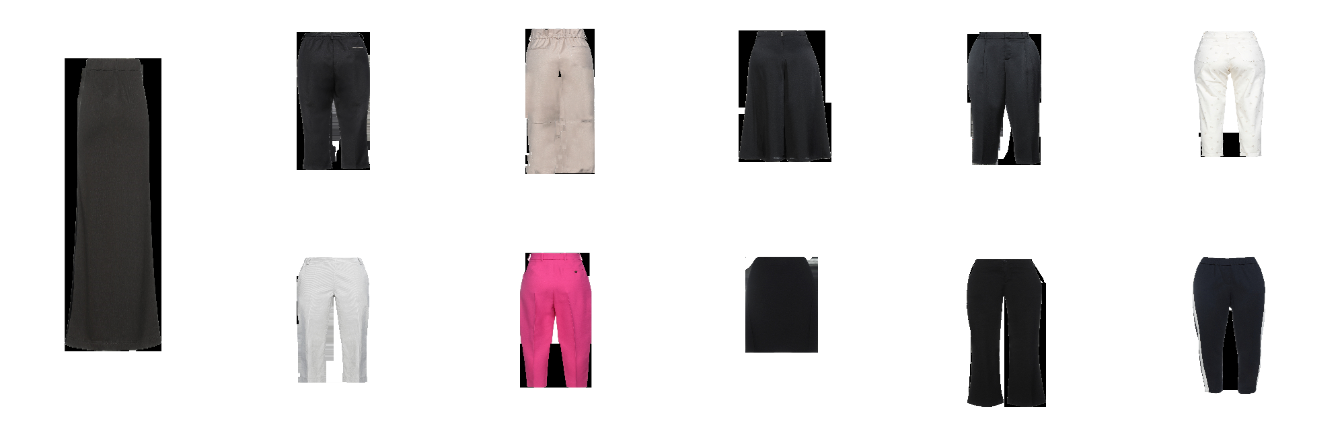

In [295]:
cv2_imshow(output)

In [296]:
sample_img_path = '/content/bottoms_resized_png/13571622DMD.png'
sample_features,sample_img = get_sample_features(sample_img_path)
indexes = get_file_indexes(sample_features)

result_list = get_images_list(indexes)
output = get_output(result_list,sample_img)

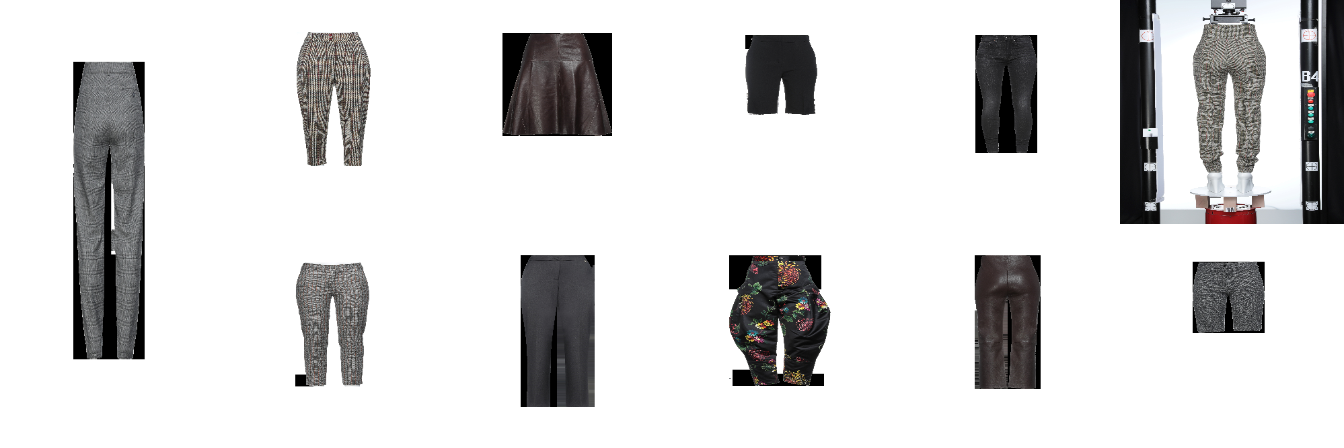

In [297]:
cv2_imshow(output)

The above generated results are from resnet-101, the embeddings are saved in provided zip file as well as in the Github link provided in the mail.

Things that I could have tried:
 --Trying some other pretrained models
 --Play with Transforms
 --Tried New Nearest Neighour finding tricks like Annoy
